In [2]:
%load_ext autoreload
%autoreload 2

## Verify implementation of divergence theorem using `sectionate` and `regionmask`

In [3]:
# Import packages
import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt

import sectionate as sec
import regionate as reg

# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")

# Set figure font size
plt.rcParams.update({'font.size':12})

### Load data (here on `z` grid, but same approach works for any vertical coordinate)

In [4]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
prefix = '19000101.ocean_'
grid = 'z'
suffix = 'thck'

filename = prefix+grid+'_'+suffix+'*.nc'
og = xr.open_mfdataset(rootdir+prefix+"static.nc")
ds = xr.open_mfdataset(rootdir+filename).isel(time=0)
ds = ds.assign_coords({
    'dxCv': xr.DataArray(og['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)),
    'dyCu': xr.DataArray(og['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',))
}) # add velocity face widths to calculate distances along the section

g_z = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                     'Y': {'center': 'yh', 'right': 'yq'},
                     'Z': {'inner': 'z_l', 'outer': 'z_i'} })

rho0 = 1035.

#### Plot thickness budget for a single depth layer

Note the large degree of compensation between horizontal convergence and remapping tendencies.

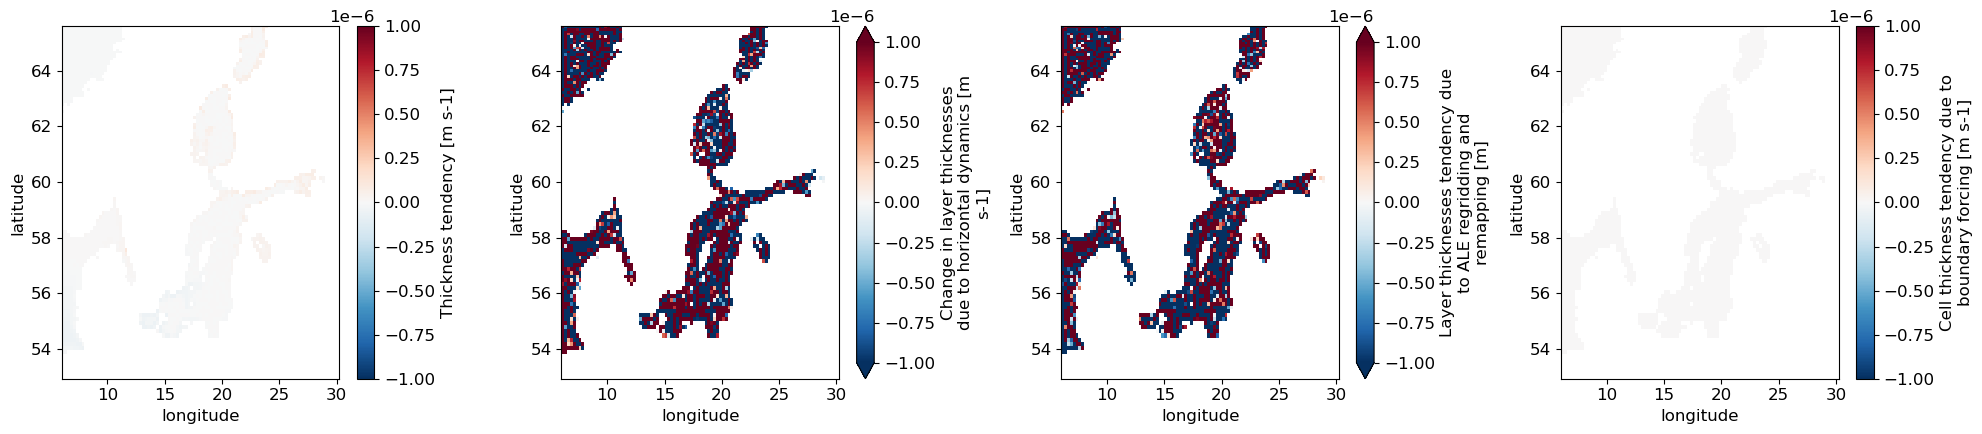

In [5]:
fig, axes = plt.subplots(1,4, figsize=(20, 4.5))
ds['dhdt'].isel(z_l=3).plot(ax=axes[0], vmin=-1e-6, vmax=1e-6, cmap="RdBu_r")
ds['dynamics_h_tendency'].isel(z_l=3).plot(ax=axes[1], vmin=-1e-6, vmax=1e-6, cmap="RdBu_r")
ds['vert_remap_h_tendency'].isel(z_l=3).plot(ax=axes[2], vmin=-1e-6, vmax=1e-6, cmap="RdBu_r")
ds['boundary_forcing_h_tendency'].isel(z_l=3).plot(ax=axes[3], vmin=-1e-6, vmax=1e-6, cmap="RdBu_r")
for ax in axes:
    ax.set_title("")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
plt.tight_layout()

#### Plot vertically-integrated thickness budget
Note the disproportionately large volume/mass inputs by river runoff at the boundaries of the Baltic sea, which is rapidly redistributed by horizontal ocean transports.

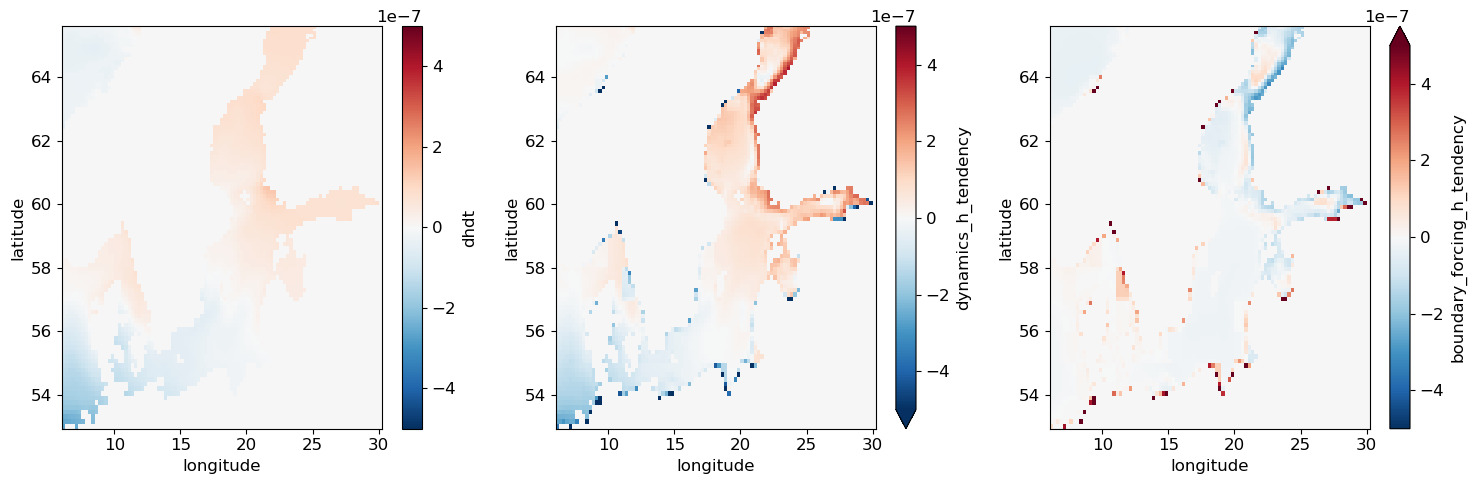

In [6]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
ds['dhdt'].sum('z_l').plot(ax=axes[0], vmin=-5e-7, vmax=5e-7, cmap="RdBu_r")
ds['dynamics_h_tendency'].sum('z_l').plot(ax=axes[1], vmin=-5e-7, vmax=5e-7, cmap="RdBu_r")
ds['boundary_forcing_h_tendency'].sum('z_l').plot(ax=axes[2], vmin=-5e-7, vmax=5e-7, cmap="RdBu_r")
for ax in axes:
    ax.set_title("")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
plt.tight_layout()

#### Define an arbitrary close sub-region of the domain defined by an irregular polygon

In [7]:
lons = np.array([13, 15, 20.5, 21.5, 19, 17])
lats = np.array([62., 53.5, 54.5, 57.1, 62, 59])
b = reg.conform_basin_to_ocean_grid(reg.Basin(lons, lats, "polygon"), og)

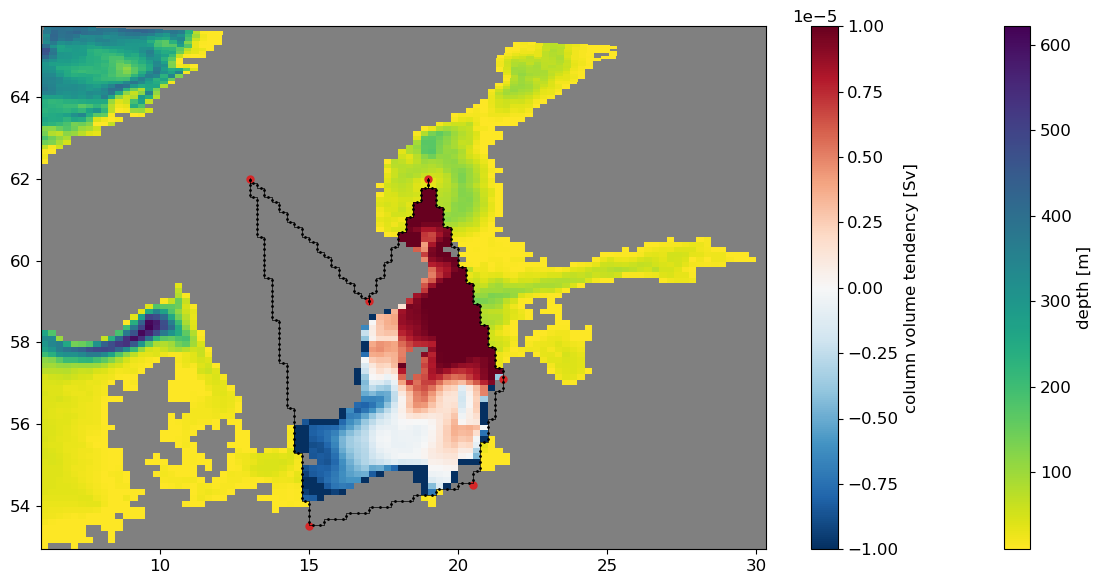

In [8]:
dhdt_dynamics = (ds['dynamics_h_tendency']*og['areacello']*1e-6).sum('z_l')
dhdt_dynamics = dhdt_dynamics.where(dhdt_dynamics!=0.)

plt.figure(figsize=(12, 6))
plt.subplot(facecolor="grey")
pc = plt.pcolormesh(
    og['geolon'], og['geolat'],
    dhdt_dynamics.where(b.mask),
    alpha=1.0, cmap="RdBu_r", vmin=-1e-5, vmax=1e-5
)
pc_dep = plt.pcolormesh(og['geolon'], og['geolat'], og.depth_ocean.where(~b.mask), cmap="viridis_r")
plt.plot(lons, lats, "C3o", markersize=5)
plt.plot(b.lons, b.lats, "k-", linewidth=0.5)
plt.plot(b.lons_uv, b.lats_uv, "k.", markersize=2.)
plt.colorbar(pc_dep, label="depth [m]")
plt.colorbar(pc, label="column volume tendency [Sv]")
plt.tight_layout()

#### Verifying the 2D Divergence theorem for area integrals over complicated sub-domains

The specific thickness equation in MOM6 is given by
\begin{equation}
\partial_{t} h + \nabla_{r} \cdot (\mathbf{u} h) + \delta_{r}(z_{r} \dot{r}) = \dot{h}.
\end{equation}

Integrating in $z$ and over a region $(x,y)\in \mathcal{R}$ (like the sub-domain defined above), the volume budget is
\begin{equation}
\partial_{t} \mathcal{V} = \iint_{\mathcal{R}} - \nabla \cdot \mathbf{U} \, \text{d}A + \dot{\mathcal{V}}. \quad\quad\text{where }\mathbf{U} \equiv \int \mathbf{u} h \,\text{d}z
\end{equation}

Applying the divergence theorem, we can rewrite
\begin{equation}
\iint_{\mathcal{R}} -\nabla \cdot \mathbf{U} \, \text{d}A = \int_{\partial \mathcal{R}}  \mathbf{U} \cdot \mathbf{n}_{in} \,\text{d}l \equiv \Psi, 
\end{equation}
with $\Psi$ the horizontally convergent volume transport. We evaluate the LHS area integral by applying a mask to the diagnosed dynamical thickness tendency term and the RHS boundary integral term by accumulating normal velocities (with positive defined inwards) along the region's boundary.

In [9]:
Ψ0_tend = dhdt_dynamics.where(b.mask).sum(['xh', 'yh']).values # LHS

symmetric = og['geolon'].shape == og['geolon_c'].shape
Tconv = sec.convergent_transport(ds, b.i, b.j, symmetric, layer="z_l", interface="z_i")
Ψ = Tconv['conv_mass_transport'].cumsum("sect").sel(z_l=ds.z_l[::-1]).cumsum('z_l').sel(z_l=ds.z_l[::-1]).compute() # kg/s
Ψ0 = Ψ.isel(sect=-1, z_l=-1).values/rho0*1e-6 # RHS

np.isclose(Ψ0, Ψ0_tend, rtol=1.e-4)

True

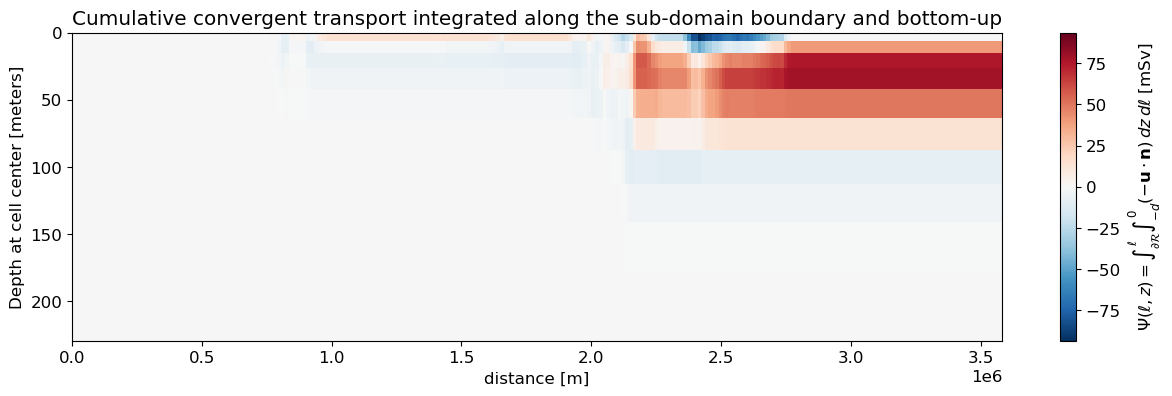

In [10]:
plt.figure(figsize=(15, 4))
pc = (Ψ/rho0*1e-3).swap_dims({'sect':'distance'}).plot(x="distance")
plt.ylim(og.where(b.mask).depth_ocean.max(), 0)
plt.title("Cumulative convergent transport integrated along the sub-domain boundary and bottom-up")
pc.colorbar.set_label(r"$\Psi(\ell, z) = \int_{\partial \mathcal{R}}^{\ell} \int_{-d}^{0} (- \mathbf{u} \cdot \mathbf{n}) \,dz\,d\ell$ [mSv]")